In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# set to be lower priority
#os.nice(1)

In [3]:
interpolations = [
        "AE",
        "AF",
        "AG",
        "AH",
        "BE",
        "BF",
        "BG",
        "BH",
        "CE",
        "CF",
        "CG",
        "CH",
        "DE",
        "DF",
        "DG",
        "DH",
    ]

In [4]:
from cdcp.paths import DATA_PATH_MAGPI, FIGURE_DIR, ensure_dir
from cdcp.general import save_fig

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/general.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
import pandas  as pd
from cdcp.paths import DATA_DIR, ensure_dir
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib2 import Path
from tqdm.autonotebook import tqdm
pd.set_option('display.max_columns', 500)
from joblib import Parallel, delayed
from datetime import datetime
from joblib import Parallel, delayed
from functools import reduce
from sklearn.decomposition import PCA
from functools import reduce


In [6]:
import seaborn as sns
from cdcp.behavior.psychometric import FourParameterLogistic, fit_FourParameterLogistic
import scipy.stats
from cdcp.spiketrain_analysis.neurometric import (
    get_interp_points_dists_from_similarity_matrix,
)

In [7]:
%matplotlib inline

In [8]:
# "2021-10-07_16-05-58_796914" '2021-10-06_13-30-08_899062' '2021-10-01_17-02-56_744915' 
statistics_timestamp = '2021-10-23_23-02-31_846685'# datetime.now().strftime("%Y-%m-%d_%H-%M-%S_%f")#
statistics_timestamp

'2021-10-23_23-02-31_846685'

In [9]:
birds = [
    ('B1597', '2021-05-14_12-40-20_423998', 'kilosort2_5'),
    ('B1188', '2021-05-31_18-52-29_558216', 'kilosort2_5'),
    ('B1595', '2021-07-10_16-42-47_090257', 'kilosort2'),
    ('B1276', '2021-07-14_11-14-02_257025', 'kilosort2'),
    ('B1426', '2021-07-14_11-29-39_657273', 'kilosort2'),
    ('B1432', '2021-06-01_15-14-38_561892', 'kilosort2_5'),
    ('B1170', '2021-06-01_21-01-26_519005', 'kilosort2_5'),
    ('B1244', '2021-07-14_12-57-45_546674', 'kilosort2'),
    ('B1593', '2021-06-28_18-13-24_826008', 'kilosort2_5'),
    ('B1248', '2021-07-03_18-08-01_063431', 'kilosort2_5'),
    # acute
    #('B1279', '2021-04-12_16-27-07_289527', 'kilosort2_5'),
    #('B1500', '2021-08-27_09-24-48_680961', 'kilosort2_5'),
    #('B1239', '2021-05-17_22-18-51_557635', 'kilosort2'),
    #('B1459', '2021-08-26_21-21-12_755614', 'kilosort2_5'),
]
birds_df = pd.DataFrame(birds, columns = ['bird', 'timestamp', 'sorter']).set_index('bird')

In [10]:
identifiers = ['spike_count', 'unit_location']# , 

In [11]:
n_interp_bins = 16

In [12]:
all_unit_statistics_df= []
for bird, timestamp, sorter in tqdm(birds, desc='birds'):
    
    unit_statistics_df_list = []
    for identifier in identifiers:

        unit_statistics_df = pd.read_pickle(
            DATA_DIR
            / "unit_statistics"
            / statistics_timestamp
            / identifier
            / "{}.pickle".format(bird)
        )
        unit_statistics_df_list.append(unit_statistics_df)
        
    print(bird, 'nrows per', [len(i) for i in unit_statistics_df_list])
    
    # combine dfs
    unit_statistics_df = reduce(lambda x, y: pd.merge(x, y, on = 'unit', how='outer'), unit_statistics_df_list)
    unit_statistics_df['bird'] = bird
    
    all_unit_statistics_df.append(unit_statistics_df)
    
unit_statistics_df = pd.concat(all_unit_statistics_df)

birds:   0%|          | 0/10 [00:00<?, ?it/s]

B1597 nrows per [6750, 8711]
B1188 nrows per [510, 821]
B1595 nrows per [242, 325]
B1276 nrows per [46, 57]
B1426 nrows per [93, 180]
B1432 nrows per [2157, 2364]
B1170 nrows per [1281, 1693]
B1244 nrows per [141, 150]
B1593 nrows per [7714, 13260]
B1248 nrows per [8698, 13184]


In [13]:
# merge with categorical units
categorical_units_df = pd.read_pickle(DATA_DIR / 'categorical_unit_01_23_22.pickle')
categorical_units_df= categorical_units_df[categorical_units_df.categorical_unit == True]
unit_statistics_df_cat = pd.merge(unit_statistics_df, categorical_units_df, on = ['bird', 'unit'])
# subset categorical units
#unit_statistics_df_cat = unit_statistics_df_cat[unit_statistics_df_cat.categorical_unit == True]
unit_statistics_df = unit_statistics_df_cat
print(len(unit_statistics_df))

### merge with unit types
unit_type_df = pd.read_pickle(DATA_DIR / "unit_classes_01_23_22.pickle")
#unit_type_df = unit_type_df[["nuclei","AP","ML","DV","amplitude","template_amplitude","sr","fw","hw","bird","unit"]]
unit_statistics_df_ut = pd.merge(unit_statistics_df, unit_type_df, on = ['bird', 'unit'])
unit_statistics_df = unit_statistics_df_ut
print(len(unit_statistics_df))

6754
6754


In [14]:
unit_statistics_df[:3]

,n_trials,n_cued_trials,n_incorrect_trials,n_correct_trials,n_reward_trials,n_passive_trials,n_active_trials,n_spikes,unit,hemisphere,labeled_region,estimated_nuclei,distance_to_estimated_nuclei,ML,AP,DV,bird,categorical_unit,categoricality,fw,sr,unit_type,best_chan_templates,best_chan_templates_norm,amplitude
0,7040,1178,258,1090,403,5597,1443,211131,6270,NaN,NaN,NCL,415.88,2917.25,2420.0,-722.499502,B1597,True,0.420068,70.0,19.505140,1,"[29.0, 28.94094094094094, 28.88188188188188, 2...","[0.04162189031853942, 0.04153712653652313, 0.0...",-515.25
1,6206,1,0,0,0,6205,1,44958,935,NaN,NaN,Field_L,503.611,2344.25,2420.0,-822.499502,B1597,True,0.265302,86.0,7.202434,0,"[29.5, 29.47047047047047, 29.44094094094094, 2...","[0.07603293844777533, 0.07595682940028006, 0.0...",-294.00
2,12810,1967,232,1925,521,10367,2443,218822,10839,NaN,NaN,CMM,250.448,1764.25,2420.0,-742.499502,B1597,True,0.296694,120.0,13.687375,0,"[42.75, 42.779529529529526, 42.80905905905906,...","[0.1011863087601332, 0.10125620312487042, 0.10...",-314.00


### get sm_differences

In [15]:
metric = "cosine"
shuffled=False
identifier = 'sm_each_cue'
stat_dfs = []
for bird, timestamp, sorter in tqdm(birds, desc='birds'):
    stat_df = pd.read_pickle(
        DATA_DIR
        / "unit_statistics"
        / statistics_timestamp
        / (identifier + "_{}_{}".format(metric, shuffled))
        / "{}.pickle".format(bird, metric, shuffled)
    )
    stat_df['bird'] = bird
    stat_dfs.append(stat_df)
    
stat_df = pd.concat(stat_dfs)

birds:   0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
# only include categorical units
stat_df = stat_df.merge(
    unit_statistics_df[["bird", "unit", "unit_type", "estimated_nuclei"]],
    on=["bird", "unit"],
)

In [17]:
stat_df_by_cue = stat_df[['bird','unit', 'cue', 'sm', 'interp']].set_index(['bird','unit', 'interp', "cue"])['sm'].unstack()

In [18]:
stat_df_by_cue[:3]

cue                                                               CL  \
bird  unit interp                                                      
B1170 1002 AE      [[0.11488749307561258, 0.1251434973360783, 0.1...   
      1027 AE      [[0.04746452663947074, 0.03745566365871532, 0....   
      1037 AE      [[0.36525143940673077, 0.38990481152974005, 0....   

cue                                                              CL0  \
bird  unit interp                                                      
B1170 1002 AE      [[0.11442067689587776, 0.13318712459387483, 0....   
      1027 AE      [[0.03692981581595229, 0.03862733140388749, 0....   
      1037 AE      [[0.3579198841935357, 0.3881325281463855, 0.38...   

cue                                                              CL1  \
bird  unit interp                                                      
B1170 1002 AE      [[0.11895915406125047, 0.1164679208363863, 0.1...   
      1027 AE      [[0.05676230116152044, 0.03657217434942476, 0....   
      1037 AE      [[0.3613829896059862, 0.3837935767646858, 0.36...   

cue                                                               CN  \
bird  unit interp                                                      
B1170 1002 AE      [[0.07779934365718641, 0.1201674569469407, nan...   
      1027 AE      [[0.04392579036840735, 0.024709889037166713, 0...   
      1037 AE      [[0.4521886636309882, 0.28098742995398573, nan...   

cue                                                               CR  \
bird  unit interp                                                      
B1170 1002 AE      [[0.14728160810515842, 0.13291420077129618, 0....   
      1027 AE      [[0.06205046227039378, 0.05381502848110543, 0....   
      1037 AE      [[0.4411148455248399, 0.3993544407439167, 0.38...   

cue                                                              CR0  \
bird  unit interp                                                      
B1170 1002 AE      [[0.16048979233778662, 0.16775167211948955, 0....   
      1027 AE      [[0.06113532208260515, 0.04815370705543371, 0....   
      1037 AE      [[0.4200897744510022, 0.41192072306986105, 0.3...   

cue                                                              CR1  \
bird  unit interp                                                      
B1170 1002 AE      [[0.12675061355872022, 0.0398126685292455, 2.8...   
      1027 AE      [[0.06126981138742152, 0.0610956787301662, 0.0...   
      1037 AE      [[0.5084697453610892, 0.43824717846495537, 0.3...   

cue                                                               NC  
bird  unit interp                                                     
B1170 1002 AE      [[0.0858863968276733, 0.08629990792105367, 0.0...  
      1027 AE      [[0.06828327441774482, 0.05797462639410615, 0....  
      1037 AE      [[0.4455007301654843, 0.39522492316429386, 0.4...

In [19]:
CL_sm = np.stack([i for i in stat_df_by_cue.CL.values if type(i) == np.ndarray])
CR_sm = np.stack([i for i in stat_df_by_cue.CR.values if type(i) == np.ndarray])
diff = np.nanmean(CL_sm - CR_sm, axis=0)

In [20]:
import matplotlib.patches as patches
from cdcp.visualization.colors import colors as cdcp_colors

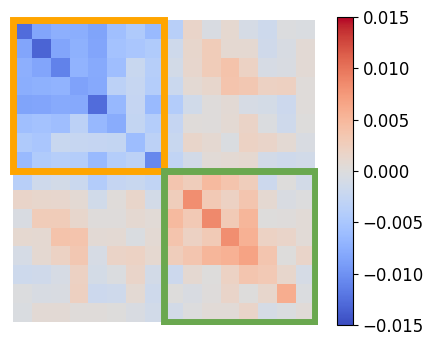

In [21]:
fig, ax = plt.subplots(figsize=(5,4))
vmin = -0.015
vmax = 0.015
im = ax.matshow(diff, vmin = vmin, vmax = vmax, cmap = 'coolwarm', extent=[0,1,0,1])
# Create a Rectangle patch
rect = patches.Rectangle((0, 0.5), 0.5, 0.5, linewidth=5, edgecolor='orange', facecolor='none')
rect2 = patches.Rectangle((0.5,0), 0.5, 0.5, linewidth=5, edgecolor=cdcp_colors['reinforce']['R']['dark'], facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
ax.add_patch(rect2)
ax.axis('off')
ax.set_xlim([-0.01,1.01])
ax.set_ylim([-0.01,1.01])
cbar = plt.colorbar(im)#, orientation='horizontal')
cbar.ax.tick_params(labelsize=12)

In [22]:
stat_df[:3]

,interp,cue,metric,sm,sm_n,shuffled,unit,bird,unit_type,estimated_nuclei
0,BF,CL,cosine,"[[0.0, 0.040445842060636124, 0.120043715935517...","[[1.0, 16.0, 14.0, 20.0, 8.0, 22.0, 16.0, 36.0...",False,3735,B1597,0,CMM
1,BF,CR,cosine,"[[0.0, 0.0, 0.5000000000000001, nan, nan, 0.0,...","[[1.0, 10.0, 2.0, 0.0, 0.0, 4.0, 6.0, 4.0, 26....",False,3735,B1597,0,CMM
2,BF,CR1,cosine,"[[nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0,...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0...",False,3735,B1597,0,CMM


### Test whether the similarity is greater for predicted or not predicted stimuli

In [23]:
stat_df_by_cue = stat_df[['bird','unit', 'cue', 'sm', 'interp']].set_index(['bird','unit', 'interp', "cue"])['sm'].unstack()
CL_sm = np.stack([i for i in stat_df_by_cue.CL.values if type(i) == np.ndarray])
CR_sm = np.stack([i for i in stat_df_by_cue.CR.values if type(i) == np.ndarray])
sm_diff = CL_sm - CR_sm
sm_diff_left = np.nanmean(sm_diff[:,:8, :8], axis=(1,2))
sm_diff_right = np.nanmean(sm_diff[:,8:, 8:], axis=(1,2))

/tmp/ipykernel_7884/1747566265.py:5: RuntimeWarning: Mean of empty slice
  sm_diff_left = np.nanmean(sm_diff[:,:8, :8], axis=(1,2))
/tmp/ipykernel_7884/1747566265.py:6: RuntimeWarning: Mean of empty slice
  sm_diff_right = np.nanmean(sm_diff[:,8:, 8:], axis=(1,2))


In [24]:
stat_df_by_cue[:3]

cue                                                               CL  \
bird  unit interp                                                      
B1170 1002 AE      [[0.11488749307561258, 0.1251434973360783, 0.1...   
      1027 AE      [[0.04746452663947074, 0.03745566365871532, 0....   
      1037 AE      [[0.36525143940673077, 0.38990481152974005, 0....   

cue                                                              CL0  \
bird  unit interp                                                      
B1170 1002 AE      [[0.11442067689587776, 0.13318712459387483, 0....   
      1027 AE      [[0.03692981581595229, 0.03862733140388749, 0....   
      1037 AE      [[0.3579198841935357, 0.3881325281463855, 0.38...   

cue                                                              CL1  \
bird  unit interp                                                      
B1170 1002 AE      [[0.11895915406125047, 0.1164679208363863, 0.1...   
      1027 AE      [[0.05676230116152044, 0.03657217434942476, 0....   
      1037 AE      [[0.3613829896059862, 0.3837935767646858, 0.36...   

cue                                                               CN  \
bird  unit interp                                                      
B1170 1002 AE      [[0.07779934365718641, 0.1201674569469407, nan...   
      1027 AE      [[0.04392579036840735, 0.024709889037166713, 0...   
      1037 AE      [[0.4521886636309882, 0.28098742995398573, nan...   

cue                                                               CR  \
bird  unit interp                                                      
B1170 1002 AE      [[0.14728160810515842, 0.13291420077129618, 0....   
      1027 AE      [[0.06205046227039378, 0.05381502848110543, 0....   
      1037 AE      [[0.4411148455248399, 0.3993544407439167, 0.38...   

cue                                                              CR0  \
bird  unit interp                                                      
B1170 1002 AE      [[0.16048979233778662, 0.16775167211948955, 0....   
      1027 AE      [[0.06113532208260515, 0.04815370705543371, 0....   
      1037 AE      [[0.4200897744510022, 0.41192072306986105, 0.3...   

cue                                                              CR1  \
bird  unit interp                                                      
B1170 1002 AE      [[0.12675061355872022, 0.0398126685292455, 2.8...   
      1027 AE      [[0.06126981138742152, 0.0610956787301662, 0.0...   
      1037 AE      [[0.5084697453610892, 0.43824717846495537, 0.3...   

cue                                                               NC  
bird  unit interp                                                     
B1170 1002 AE      [[0.0858863968276733, 0.08629990792105367, 0.0...  
      1027 AE      [[0.06828327441774482, 0.05797462639410615, 0....  
      1037 AE      [[0.4455007301654843, 0.39522492316429386, 0.4...

In [25]:
sm_df = pd.DataFrame({
    'subject': np.tile(np.array(stat_df_by_cue.index.get_level_values('bird')),2),
    'unit': np.tile(np.array(stat_df_by_cue.index.get_level_values('unit')),2),
    'sm_diff': np.concatenate([sm_diff_left, sm_diff_right]),
    'side': np.concatenate([np.repeat('L', len(sm_diff_left)), np.repeat('R', len(sm_diff_right))])
})
sm_df = sm_df[sm_df.sm_diff.isnull() == False]

In [26]:
sm_df[:3]

,subject,unit,sm_diff,side
0,B1170,1002,0.005066,L
1,B1170,1027,-0.007904,L
2,B1170,1037,0.017706,L


In [27]:
len(sm_df)

44749

In [28]:
df = sm_df

In [29]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [35]:
# Mixed Linear Model
model = smf.mixedlm("sm_diff ~ side", df, groups=df["unit"], re_formula="1 + side")
result = model.fit()

/n/groups/datta/tim_sainburg/conda_envs/cdcp_paper/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/n/groups/datta/tim_sainburg/conda_envs/cdcp_paper/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/n/groups/datta/tim_sainburg/conda_envs/cdcp_paper/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [36]:
# Summary of the model
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    sm_diff   
No. Observations:    44749      Method:                REML      
No. Groups:          4705       Scale:                 0.0063    
Min. group size:     1          Log-Likelihood:        46403.4045
Max. group size:     42         Converged:             Yes       
Mean group size:     9.5                                         
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept             -0.007    0.001 -10.108 0.000 -0.008 -0.005
side[T.R]              0.009    0.001  10.100 0.000  0.008  0.011
Group Var              0.001    0.000                            
Group x side[T.R] Cov  0.001                                     
side[T.R] Var          0.001    0.001                            
=================================================================

"""

### Test the relationship between cue probability and similarity

In [37]:
p_left = {
    "CL1": 0.875,
    'CL0': 0.75,
    'CN': 0.5,
    'CR0': 0.25,
    'CR1': 0.125,
}

In [38]:
import copy

In [39]:
stat_df_by_cue_rel_CN = copy.deepcopy(stat_df_by_cue)
for cue in ['CL1', 'CL0', 'CR0', 'CR1']:
    stat_df_by_cue_rel_CN[cue] = stat_df_by_cue[cue].values - stat_df_by_cue['CN'].values
    stat_df_by_cue_rel_CN = stat_df_by_cue_rel_CN[['CL1', 'CL0', 'CR0', 'CR1']]

In [40]:
stat_df_by_cue_rel_CN[:3]

cue                                                              CL1  \
bird  unit interp                                                      
B1170 1002 AE      [[0.041159810404064065, -0.0036995361105544022...   
      1027 AE      [[0.012836510793113085, 0.011862285312258046, ...   
      1037 AE      [[-0.090805674025002, 0.10280614681070005, nan...   

cue                                                              CL0  \
bird  unit interp                                                      
B1170 1002 AE      [[0.03662133323869135, 0.01301966764693413, na...   
      1027 AE      [[-0.006995974552455063, 0.013917442366720774,...   
      1037 AE      [[-0.09426877943745249, 0.10714509819239976, n...   

cue                                                              CR0  \
bird  unit interp                                                      
B1170 1002 AE      [[0.08269044868060021, 0.04758421517254885, na...   
      1027 AE      [[0.017209531714197798, 0.023443818018266997, ...   
      1037 AE      [[-0.03209888917998599, 0.13093329311587532, n...   

cue                                                              CR1  
bird  unit interp                                                     
B1170 1002 AE      [[0.04895126990153381, -0.0803547884176952, na...  
      1027 AE      [[0.017344021019014166, 0.036385789692999486, ...  
      1037 AE      [[0.056281081730101046, 0.15725974851096963, n...

In [41]:
len(stat_df_by_cue_rel_CN)

25936

In [42]:
all_shifts = []
all_probs = []
all_unit = []
for cue in ['CL1', 'CL0', 'CR0', 'CR1']:
    L = np.nanmean(np.stack(stat_df_by_cue_rel_CN[cue])[:, :8, :8], axis=(1,2)).flatten()
    R = np.nanmean(np.stack(stat_df_by_cue_rel_CN[cue])[:, 8:, 8:], axis=(1,2)).flatten()
    unit = stat_df_by_cue_rel_CN[cue].index.get_level_values('unit')
    
    unit = np.concatenate([unit[(np.isnan(L) == False)], unit[(np.isnan(R) == False)]])
    L =  L[np.isnan(L) == False] 
    R =  R[np.isnan(R) == False] 
    
    shift = np.concatenate([L, R])
    probs = np.concatenate([np.ones(len(L)) * p_left[cue], np.ones(len(R)) * (1 - p_left[cue])])
    all_shifts.append(shift)
    all_probs.append(probs)
    all_unit.append(unit)
    #break
all_shifts = np.concatenate(all_shifts)
all_probs = np.concatenate(all_probs)
all_unit = np.concatenate(all_unit)

/tmp/ipykernel_7884/1976604311.py:5: RuntimeWarning: Mean of empty slice
  L = np.nanmean(np.stack(stat_df_by_cue_rel_CN[cue])[:, :8, :8], axis=(1,2)).flatten()
/tmp/ipykernel_7884/1976604311.py:6: RuntimeWarning: Mean of empty slice
  R = np.nanmean(np.stack(stat_df_by_cue_rel_CN[cue])[:, 8:, 8:], axis=(1,2)).flatten()


In [47]:
len(all_probs), len(all_unit), len(all_shifts)

(108153, 108153, 108153)

In [44]:
similarity_shift_df = pd.DataFrame({
    'unit': all_unit,
    'similarity_rel_CN': all_shifts,
    'p_stim' : all_probs
})

In [48]:
similarity_shift_df[:3]

,unit,similarity_rel_CN,p_stim
0,1002,-0.036425,0.875
1,1027,0.007498,0.875
2,1037,-0.004476,0.875


In [49]:
df = similarity_shift_df

In [50]:
# Mixed Linear Model
model = smf.mixedlm("similarity_rel_CN ~ p_stim", df, groups=df["unit"], re_formula="1 + p_stim")
result = model.fit()

/n/groups/datta/tim_sainburg/conda_envs/cdcp_paper/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/n/groups/datta/tim_sainburg/conda_envs/cdcp_paper/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/n/groups/datta/tim_sainburg/conda_envs/cdcp_paper/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [51]:
# Summary of the model
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:            MixedLM Dependent Variable: similarity_rel_CN
No. Observations: 108153  Method:             REML             
No. Groups:       4559    Scale:              0.0191           
Min. group size:  1       Log-Likelihood:     58391.2131       
Max. group size:  101     Converged:          Yes              
Mean group size:  23.7                                         
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.001    0.001 -1.032 0.302 -0.004  0.001
p_stim               -0.010    0.001 -7.018 0.000 -0.013 -0.007
Group Var             0.002    0.001                           
Group x p_stim Cov   -0.001    0.001                           
p_stim Var            0.000    0.002                           
===============================================================

"""